In [1]:
from paretoGraphInfluence import *
import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

# Import influence datasets
data_path_HEPT = '../../datasets/raw_data/influence/NetHEPT/hep.txt'
data_path_PHY = '../../datasets/raw_data/influence/NetPHY/phy.txt'

G_HEPT = import_influence_data(data_path_HEPT)
G_PHY = import_influence_data(data_path_PHY)

2026-02-07 21:03:09,041 |INFO: Imported influence graph with 1673 nodes and 3863 edges
2026-02-07 21:03:10,319 |INFO: Imported influence graph with 912 nodes and 8748 edges


In [2]:
def findApproximateParetoSolutionsInfluenceGraph(G, num_samples=10, num_runs=5, sample_size=200, maxDiameter=None, dataset_name=""):
    '''
    Run graph-diameter algorithms over multiple runs and plot mean +/- std (Influence vs Diameter).
    Parameters:
    - G: Graph
    - num_samples: Number of Monte Carlo samples per run
    - num_runs: Number of independent runs
    - sample_size: Optional node subsample size
    - maxDiameter: Optional diameter max for plotting grid
    - dataset_name: Name of the dataset for plotting
    '''
    algo_names = ["ParetoGreedy-Diameter", "PruneGraph", "PlainGreedy", "TopK-degree"]

    all_influences = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    cgreedy_size_counts = []
    prune_size_counts = []
    distance_size_counts = []
    topk_size_counts = []

    for run_idx in range(num_runs):
        subG, sub_nodes = sample_graph(G, sample_size=sample_size, seed=run_idx)
        pairwise_costs, sub_nodes = compute_pairwise_costs_from_graph(subG, sub_nodes)

        if maxDiameter is None:
            maxDiameter_run = 1.5 * float(np.max(pairwise_costs)) if pairwise_costs.size > 0 else 1.0
        else:
            maxDiameter_run = maxDiameter

        num_steps, min_diameter = 8, 0.0
        diameter_arr = np.linspace(min_diameter, maxDiameter_run, num_steps)

        def align_to_diameter_arr(diameters, infls):
            if len(diameters) == 0 or len(infls) == 0:
                return np.full_like(diameter_arr, np.nan, dtype=float)
            diameters = np.array(diameters, dtype=float)
            infls = np.array(infls, dtype=float)
            min_len = min(len(diameters), len(infls))
            diameters = diameters[:min_len]
            infls = infls[:min_len]
            agg = {}
            for d, c in zip(diameters, infls):
                if d in agg:
                    agg[d] = max(agg[d], c)
                else:
                    agg[d] = c
            if len(agg) == 0:
                return np.full_like(diameter_arr, np.nan, dtype=float)
            diameters_sorted = np.array(sorted(agg.keys()), dtype=float)
            infls_sorted = np.array([agg[d] for d in diameters_sorted], dtype=float)
            return np.interp(diameter_arr, diameters_sorted, infls_sorted, left=infls_sorted[0], right=infls_sorted[-1])

        graph_samples = None
        if num_samples is not None and num_samples > 0:
            pareto_tmp = paretoGraphInfluence(G=subG, pairwise_costs=pairwise_costs, nodes=sub_nodes, num_samples=num_samples)
            graph_samples = pareto_tmp.graph_samples

        run_influences = {alg: [] for alg in algo_names}
        run_runtimes = {alg: [] for alg in algo_names}

        pareto = paretoGraphInfluence(G=subG, pairwise_costs=pairwise_costs, nodes=sub_nodes, num_samples=num_samples, graph_samples=graph_samples)
        diameters, best_infl, _, _, runTime = pareto.ParetoGreedyDiameter()
        run_influences['ParetoGreedy-Diameter'] = list(align_to_diameter_arr(diameters, best_infl))
        run_runtimes['ParetoGreedy-Diameter'].append(runTime)
        cgreedy_size_counts.append(len(diameters))

        pg_diam, pg_infl, _, _, pg_time = pareto.plainGreedyDistanceScaled()
        run_influences['PlainGreedy'] = list(align_to_diameter_arr(pg_diam, pg_infl))
        run_runtimes['PlainGreedy'].append(pg_time)
        distance_size_counts.append(len(pg_diam))

        tk_diam, tk_infl, _, _, tk_time = pareto.topKDistanceScaled()
        run_influences['TopK-degree'] = list(align_to_diameter_arr(tk_diam, tk_infl))
        run_runtimes['TopK-degree'].append(tk_time)
        topk_size_counts.append(len(tk_diam))

        pr_radii, pr_infl, _, _, pr_time = pareto.graphPruning()
        run_influences['PruneGraph'] = list(align_to_diameter_arr(pr_radii, pr_infl))
        run_runtimes['PruneGraph'].append(pr_time)
        prune_size_counts.append(len(pr_radii))

        for alg in algo_names:
            arr = np.array(run_influences[alg], dtype=float)
            if arr.size == 0:
                arr = np.full_like(diameter_arr, np.nan, dtype=float)
            all_influences[alg].append(arr)
            runtimes = run_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

    mean_influences = {}
    std_influences = {}
    for alg in algo_names:
        stacked = np.vstack(all_influences[alg])
        mean_influences[alg] = np.nanmean(stacked, axis=0)
        std_influences[alg] = np.nanstd(stacked, axis=0)

    mean_cgreedy_size = float(np.mean(cgreedy_size_counts)) if len(cgreedy_size_counts) > 0 else 0.0
    mean_prune_size = float(np.mean(prune_size_counts)) if len(prune_size_counts) > 0 else 0.0
    mean_distance_size = float(np.mean(distance_size_counts)) if len(distance_size_counts) > 0 else 0.0
    mean_topk_size = float(np.mean(topk_size_counts)) if len(topk_size_counts) > 0 else 0.0

    mean_frontier_sizes = {
        "ParetoGreedy-Diameter": mean_cgreedy_size,
        "PruneGraph": mean_prune_size,
        "PlainGreedy": mean_distance_size,
        "TopK-degree": mean_topk_size,
    }

    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "ParetoGreedy-Diameter": tab10_colors[2],
        "PruneGraph": tab10_colors[3],
        "PlainGreedy": tab10_colors[1],
        "TopK-degree": tab10_colors[0],
    }
    marker_map = {
        "ParetoGreedy-Diameter": "X",
        "PruneGraph": "o",
        "PlainGreedy": "s",
        "TopK-degree": "^",
    }
    linestyle_map = {
        "ParetoGreedy-Diameter": (0, (3, 2)),
        "PruneGraph": (0, (4, 2)),
        "PlainGreedy": (0, (2, 2)),
        "TopK-degree": (0, (1, 1)),
    }

    fig, ax = plt.subplots(figsize=(9, 5.5))
    rng = np.random.default_rng()

    def pick_marker_indices(count):
        if diameter_arr.size == 0 or count <= 0:
            return np.array([], dtype=int)
        count = int(max(2, min(diameter_arr.size, count)))
        if count == 1:
            return np.array([0], dtype=int)
        step = (diameter_arr.size - 1) / float(count - 1)
        max_offset = max(0.0, step - 1.0)
        offset = rng.uniform(0.0, max_offset) if max_offset > 0 else 0.0
        idx = np.round(offset + step * np.arange(count)).astype(int)
        idx = np.clip(idx, 0, diameter_arr.size - 1)
        idx = np.unique(idx)
        if idx.size < 2:
            idx = np.unique(np.round(np.linspace(0, diameter_arr.size - 1, count)).astype(int))
        return idx

    for i, alg in enumerate(algo_names):
        mean = mean_influences[alg]
        std = std_influences[alg] * 0.5
        is_pareto = alg == "ParetoGreedy-Diameter"
        marker_size = 7 if is_pareto else 6
        line_style = linestyle_map.get(alg, (0, (1, 1)))

        color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
        marker = marker_map.get(alg, "o")
        zorder = 4 if is_pareto else 3

        ax.plot(diameter_arr, mean,
                color=color,
                linestyle=line_style,
                linewidth=1.8,
                zorder=zorder)
        marker_count = int(np.round(mean_frontier_sizes.get(alg, 0.0)))
        marker_idx = pick_marker_indices(marker_count)
        if marker_idx.size > 0:
            ax.scatter(diameter_arr[marker_idx], mean[marker_idx],
                       color=color,
                       marker=marker,
                       s=marker_size**2,
                       edgecolor='k',
                       linewidths=0.6,
                       zorder=zorder + 1)
        ax.fill_between(diameter_arr,
                        np.clip(mean - std, 0, None),
                        np.clip(mean + std, 0, None),
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Seed diameter, $c_d$', fontsize=28)
    ax.set_ylabel(r'Expected influence, $f$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "graph"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_graph.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

    dataset_label = dataset_name or "dataset"
    dataset_macro = rf"\\dataset{{{dataset_label}}}"
    mean_cgreedy_rt = float(np.mean(all_runtimes['ParetoGreedy-Diameter'])) if len(all_runtimes['ParetoGreedy-Diameter']) > 0 else 0.0
    mean_prune_rt = float(np.mean(all_runtimes['PruneGraph'])) if len(all_runtimes['PruneGraph']) > 0 else 0.0
    mean_distance_rt = float(np.mean(all_runtimes['PlainGreedy'])) if len(all_runtimes['PlainGreedy']) > 0 else 0.0
    mean_topk_rt = float(np.mean(all_runtimes['TopK-degree'])) if len(all_runtimes['TopK-degree']) > 0 else 0.0
    runtime_row = (
        f"{dataset_macro} "
        f"& {mean_cgreedy_rt:.3f} "
        f"& {mean_prune_rt:.3f} "
        f"& {mean_distance_rt:.3f} "
        f"& {mean_topk_rt:.3f} \\\\"
    )
    logging.info(runtime_row)

    frontier_row = (
        f"{dataset_macro} "
        f"& {mean_cgreedy_size:.3f} "
        f"& {mean_prune_size:.3f} "
        f"& {mean_distance_size:.3f} "
        f"& {mean_topk_size:.3f} \\\\"
    )
    logging.info(frontier_row)

    summary_dir = plots_dir / "summary"
    summary_dir.mkdir(parents=True, exist_ok=True)
    runtimes_path = summary_dir / "runtimes.txt"
    frontier_path = summary_dir / "frontier-size.txt"
    with open(runtimes_path, "a", encoding="utf-8") as runtime_file:
        runtime_file.write(runtime_row + "\n")
    with open(frontier_path, "a", encoding="utf-8") as frontier_file:
        frontier_file.write(frontier_row + "\n")

    return None


### NetPHY Experiments

2026-02-07 21:03:11,163 |INFO: Initialized Pareto Influence - Graph Cost Instance, Num Nodes:912
2026-02-07 21:03:11,163 |INFO: Initialized Pareto Influence - Graph Cost Instance, Num Nodes:912
2026-02-07 21:03:12,636 |INFO: GreedyThresholdDiameter finished: max_influence=140.000, runtime=1.465s
2026-02-07 21:03:12,636 |INFO: GreedyThresholdDiameter solutions: (d=0.000, infl=6.000, |S|=1); (d=0.001, infl=8.200, |S|=4); (d=0.001, infl=12.600, |S|=7); (d=0.002, infl=31.400, |S|=57); (d=0.138, infl=33.800, |S|=69); (d=0.519, infl=34.600, |S|=87); (d=0.824, infl=36.000, |S|=97); (d=96.589, infl=140.000, |S|=901)
2026-02-07 21:09:33,176 |INFO: PlainGreedyDistanceScaled finished: max_influence=140.000, runtime=380.537s
2026-02-07 21:09:33,179 |INFO: PlainGreedyDistanceScaled solutions: (d=0.000, infl=6.000, |S|=1); (d=2.685, infl=33.800, |S|=94); (d=96.589, infl=140.000, |S|=912)
2026-02-07 21:09:34,704 |INFO: TopKDistanceScaled finished: max_influence=140.000, runtime=1.523s
2026-02-07 21:0

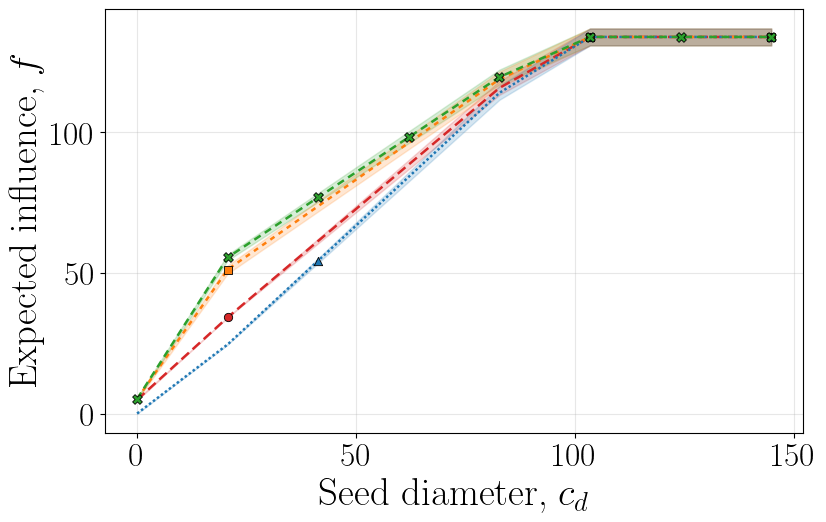

2026-02-07 21:21:07,524 |INFO: \\dataset{NetPHY} & 1.521 & 152.318 & 382.095 & 1.474 \\
2026-02-07 21:21:07,527 |INFO: \\dataset{NetPHY} & 8.500 & 2.500 & 3.000 & 3.000 \\


In [3]:
# Parameters
num_samples = 5
num_runs = 2
sample_size = 912

# Run for NetPHY
findApproximateParetoSolutionsInfluenceGraph(G_PHY, num_samples=num_samples, num_runs=num_runs, 
                                             sample_size=sample_size, dataset_name="NetPHY")

### NetHEPT Experiments

2026-02-07 21:21:09,282 |INFO: Initialized Pareto Influence - Graph Cost Instance, Num Nodes:1673
2026-02-07 21:21:09,283 |INFO: Initialized Pareto Influence - Graph Cost Instance, Num Nodes:1673
2026-02-07 21:21:14,273 |INFO: GreedyThresholdDiameter finished: max_influence=69.600, runtime=4.950s
2026-02-07 21:21:14,275 |INFO: GreedyThresholdDiameter solutions: (d=0.000, infl=2.400, |S|=1); (d=0.050, infl=8.600, |S|=22); (d=0.456, infl=10.400, |S|=36); (d=1.637, infl=11.200, |S|=48); (d=2.330, infl=12.000, |S|=54); (d=3.136, infl=12.400, |S|=61); (d=4.235, infl=13.200, |S|=79); (d=5.276, infl=13.600, |S|=99); (d=8.108, infl=14.000, |S|=110); (d=8.194, infl=14.400, |S|=113); (d=8.559, infl=14.800, |S|=117); (d=10.769, infl=15.200, |S|=133); (d=11.220, infl=15.600, |S|=147); (d=14.540, infl=15.800, |S|=567); (d=194.287, infl=69.600, |S|=1636)
2026-02-07 22:21:53,645 |INFO: PlainGreedyDistanceScaled finished: max_influence=69.600, runtime=3639.317s
2026-02-07 22:21:53,647 |INFO: PlainGree

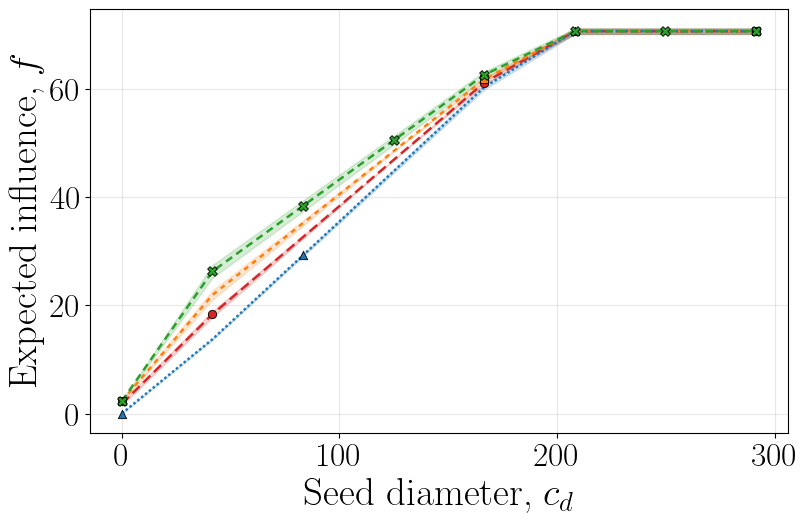

2026-02-07 23:39:35,389 |INFO: \\dataset{NetHEPT} & 4.727 & 665.215 & 3468.750 & 13.330 \\
2026-02-07 23:39:35,390 |INFO: \\dataset{NetHEPT} & 26.500 & 3.000 & 3.000 & 4.000 \\


In [4]:
# Parameters
num_samples = 5
num_runs = 2
sample_size = 1673
findApproximateParetoSolutionsInfluenceGraph(G_HEPT, num_samples=num_samples, num_runs=num_runs, sample_size=sample_size, dataset_name="NetHEPT")